In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from typing import Literal, DefaultDict, Dict, List, Tuple
from collections import defaultdict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn import model_selection, preprocessing
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv("../datasets/ml-latest-small/ratings.csv")
df.rename(
    columns={"userId": "user_id", "movieId": "item_id", "timestamp": "ts"}, inplace=True
)
df.info()

stats_df = {
    "n_users": df.user_id.nunique(),
    "n_items": df.item_id.nunique(),
    "n_ratings": df.shape[0],
}

print("\n\n", pd.DataFrame(stats_df, index=[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  100836 non-null  int64  
 1   item_id  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   ts       100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


    n_users  n_items  n_ratings
1      610     9724     100836


rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64


<BarContainer object of 10 artists>

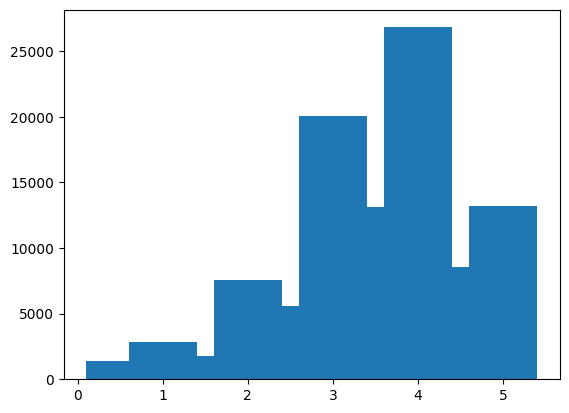

In [6]:
rating_dist = df.rating.value_counts()
print(rating_dist)
plt.bar(rating_dist.index, rating_dist.values)

#### **Predict Ratings**

In [7]:
class ItemDataset(Dataset):
    def __init__(self, users, items, targets):
        self.users = users
        self.items = items
        self.targets = targets

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        items = self.items[item]
        targets = self.targets[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "items": torch.tensor(items, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long),
        }


class RecSysModel(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32):
        """
        emb_dim = 32

        item and user embeddings get concatenated, resulting in an embedding with 64d.

        layers (3): 64d - 32d - 16d (2 hidden layers + output layer / last hidden layer)
        """

        super().__init__()

        # learnable paramters - user and item embedding matrices
        # user embedding matrix size = n_users x emb_dim
        # item embedding matrix size = n_items x emb_dim
        self.user_matrix_embedding = nn.Embedding(n_users, emb_dim)
        self.item_matrix_embedding = nn.Embedding(n_items, emb_dim)

        # single linear layer: 64 -> 1
        self.output = nn.Linear(2 * emb_dim, 1)

    def forward(self, user_ids, item_ids, targets=None):
        """
        Zero hidden layers.

        All it does: for the 64d concatenated embedding, it outputs a single value that
        passes through a linear layer.
        """
        user_embeddings = self.user_matrix_embedding(user_ids)
        item_embeddings = self.item_matrix_embedding(item_ids)

        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        output = self.output(x)

        return output

**Datasets construction**

In [8]:
# encode the user and item id to start from 0
# this prevents us from run into index out of bound "error" with Embedding lookup
lbl_user = preprocessing.LabelEncoder()
lbl_item = preprocessing.LabelEncoder()

df.user_id = lbl_user.fit_transform(df.user_id.values)
df.item_id = lbl_item.fit_transform(df.item_id.values)

In [9]:
df_train, df_test = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = ItemDataset(
    users=df_train.user_id.values,
    items=df_train.item_id.values,
    targets=df_train.rating.values,
)

test_dataset = ItemDataset(
    users=df_test.user_id.values,
    items=df_test.item_id.values,
    targets=df_test.rating.values,
)

print(
    "Lengths: train set = {}; test set = {}".format(
        len(train_dataset), len(test_dataset)
    )
)

Lengths: train set = 90752; test set = 10084


In [10]:
"""
total number of batches = nb. training points / batch_size
"""

train_loader = DataLoader(
    dataset=train_dataset, batch_size=4, shuffle=True, num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=4, shuffle=True, num_workers=2
)

dataiter = iter(train_loader)
print(next(dataiter))

{'users': tensor([ 50, 605, 345, 447]), 'items': tensor([1145,  711, 4414,  775]), 'targets': tensor([5, 4, 4, 3])}


In [11]:
n_users = len(lbl_user.classes_)
n_items = len(lbl_item.classes_)

model = RecSysModel(n_users=n_users, n_items=n_items).to(device)

optimizer = torch.optim.Adam(model.parameters())

# Every `step_size` calls to scheduler.step(), multiply the learning rate by `gamma`
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [12]:
print("n_users: {}; n_items: {} \n".format(n_users, n_items))

for p in model.parameters():
    print(p.shape)

"""
Parameters
----------
user_matrix_embedding.weight  torch.Size([n_users, 32])
item_matrix_embedding.weight  torch.Size([n_items, 32])
output.weight                 torch.Size([1, 64])
output.bias                   torch.Size([1])
"""

n_users: 610; n_items: 9724 

torch.Size([610, 32])
torch.Size([9724, 32])
torch.Size([1, 64])
torch.Size([1])


'\nParameters\n----------\nuser_matrix_embedding.weight  torch.Size([n_users, 32])\nitem_matrix_embedding.weight  torch.Size([n_items, 32])\noutput.weight                 torch.Size([1, 64])\noutput.bias                   torch.Size([1])\n'

**Forward Pass Example**

**Training Loop**

In [13]:
epochs = 1  # nb. of times we go through the train set
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
"""
- Puts the model into "training mode"

- It changes how some layers behave:
    1. Dropout layers (nn.Dropout)
        - In train() mode: randomly zero out some activations (adds noise, regularizes).
        - In eval() mode: no dropout, they pass everything through (but scaled 
        appropriately during training).

    2. BatchNorm layers (nn.BatchNorm1d, nn.BatchNorm2d, etc.)
        (it fixes the "internal covariate shift" problem)
        - In train() mode: use the current batch's mean/variance and update running stats.
        - In eval() mode: use the stored running mean/variance (fixed statistics).
"""


for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        # move data to device
        users = train_data["users"].to(device)
        items = train_data["items"].to(device)
        targets = train_data["targets"].to(device)

        # foward pass
        pred_target = model(users, items)
        true_target = targets.view(targets.size(0), -1).to(torch.float32)
        loss = loss_func(pred_target, true_target)
        total_loss += loss.sum().item()

        # clears old gradients from previous iteration
        optimizer.zero_grad()
        # backpropagation: performs backward propragation
        # (fills param.grad for every parameter in model.parameters())
        loss.backward()
        # param update: uses the gradients in param.grads to update the parameters
        optimizer.step()

        step_cnt += len(train_data["users"])

        # for plot purposes
        if step_cnt % plot_steps == 0:
            avg_loss = total_loss / (len(train_data["users"]) * plot_steps)
            print("epoch {} loss at step {} os {}".format(epoch_i, step_cnt, avg_loss))
            all_losses_list.append(avg_loss)
            total_loss = 0  # reset total loss

epoch 0 loss at step 5000 os 0.49860034563485534
epoch 0 loss at step 10000 os 0.18102472758591176
epoch 0 loss at step 15000 os 0.10387139987698756
epoch 0 loss at step 20000 os 0.08159944907939061
epoch 0 loss at step 25000 os 0.07275029702670872
epoch 0 loss at step 30000 os 0.06522287025479599
epoch 0 loss at step 35000 os 0.06625313454847782
epoch 0 loss at step 40000 os 0.06140692679232452
epoch 0 loss at step 45000 os 0.062055559551948684
epoch 0 loss at step 50000 os 0.06032266842843965
epoch 0 loss at step 55000 os 0.05916073744990863
epoch 0 loss at step 60000 os 0.06166938542379066
epoch 0 loss at step 65000 os 0.061935593848209826
epoch 0 loss at step 70000 os 0.05753230524677783
epoch 0 loss at step 75000 os 0.05971537412470206
epoch 0 loss at step 80000 os 0.056061960330884904
epoch 0 loss at step 85000 os 0.058748334422195334
epoch 0 loss at step 90000 os 0.0575647728565149


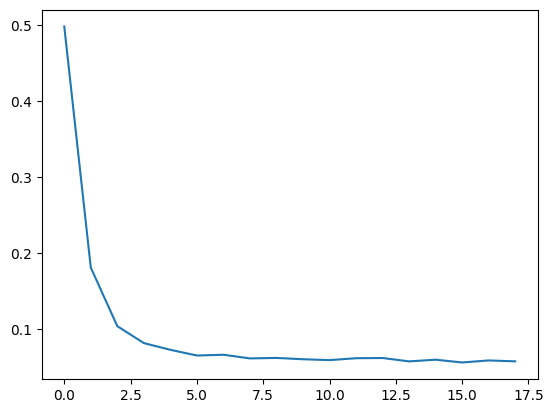

In [14]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

**Evaluation Loop w/ RMSE**

In [15]:
def compute_rmse(
    model: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    mode: Literal["per_sample", "batch_mean"] = "per_sample",
    verbose: bool = False,
) -> float:
    """
    Compute RMSE on a test set using either per-sample or per-batch-mean aggregation.

    Each batch from `test_loader` is expected to be a dict with keys:
        - "users": user IDs (ignored for the metric)
        - "items": item IDs (ignored for the metric)
        - "targets": true ratings

    Parameters
    ----------
    model
        Trained PyTorch model that takes (users, items) and outputs predictions.
    test_loader
        DataLoader yielding batches as dicts with "users", "items", "targets".
    device
        Device on which to run inference (e.g., torch.device("cuda") or torch.device("cpu")).
    mode
        Valid values:
        - "per_sample": standard RMSE over all individual predictions.
        - "batch_mean": RMSE over per-batch mean predictions vs. per-batch mean targets.
    verbose
        If True, prints predictions and targets per batch.

    Returns
    -------
    rmse
        The computed root mean squared error as a float.
    """
    model.eval()

    pred_list = []
    true_list = []

    with torch.no_grad():
        for batch in test_loader:
            users = batch["users"].to(device)
            items = batch["items"].to(device)
            targets = batch["targets"].to(device)

            preds = model(users, items)
            trues = targets.view(targets.size(0), -1).to(torch.float32)

            if mode == "per_sample":
                # Standard RMSE across all individual samples
                pred_list += preds.view(-1).cpu().tolist()
                true_list += trues.view(-1).cpu().tolist()

            elif mode == "batch_mean":
                # RMSE of per-batch averages
                batch_pred_mean = preds.mean().item()
                batch_true_mean = trues.mean().item()
                pred_list.append(batch_pred_mean)
                true_list.append(batch_true_mean)

            else:
                raise ValueError(
                    f"Unknown mode: {mode}. Use 'per_sample' or 'batch_mean'."
                )

            if verbose:
                print(f"Predictions: {preds}")
                print(f"Targets: {trues}")

    rmse = root_mean_squared_error(true_list, pred_list)
    return rmse

In [ ]:
# Standard, accurate RMSE over all individual ratings
rmse_per_sample = compute_rmse(model, test_loader, device, mode="per_sample")
print("Per-sample RMSE: {}".format(np.round(rmse_per_sample, 4)))

# RMSE over per-batch means (coarser aggregate)
rmse_batch_mean = compute_rmse(model, test_loader, device, mode="batch_mean")
print("Batch-sample RMSE: {}".format(np.round(rmse_batch_mean, 4)))

Per-sample RMSE: 0.9478
Batch-sample RMSE: 0.4805


**Evaluation Loop w/ Recall & Precision**

Recall@k = # of recommended items @k that are relevant / total # of relevant items

Precision@k = # of recommended items @k that are relevant / # of recommended items @k


In [17]:
def collect_user_predictions(
    model: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    verbose: bool = False,
) -> Dict[int, List[Tuple[float, float]]]:
    """
    Run the model on the test set and collect predicted and true targets per user.

    Each batch from `test_loader` is expected to be a dict with keys:
    - "users": user IDs
    - "items": item IDs
    - "targets": true target values (e.g., ratings, clicks, scores, etc.)

    Parameters
    ----------
    model
        Trained PyTorch model that takes (users, items) and outputs predictions.
    test_loader
        DataLoader yielding test batches as dicts with "users", "items", "targets".
    device
        Device on which to run inference (e.g., torch.device("cuda") or torch.device("cpu")).
    verbose
        If True, prints predictions and targets per batch.

    Returns
    -------
    user_pred_true
        A dictionary mapping each user_id (int) to a list of (predicted_value, true_value)
        tuples.
    """
    model.eval()
    user_pred_true: DefaultDict[int, List[Tuple[float, float]]] = defaultdict(list)

    with torch.no_grad():
        for batch in test_loader:
            users = batch["users"].to(device)
            items = batch["items"].to(device)
            targets = batch["targets"].to(device)

            pred_target = model(users, items)
            true_target = targets.view(targets.size(0), -1).to(torch.float32)

            for idx in range(len(users)):
                user_id = users[idx].item()
                item_id = items[idx].item()
                pred = pred_target[idx][0].item()
                true = true_target[idx][0].item()

                if verbose:
                    print("{}, {}, {}, {}".format(user_id, item_id, pred, true))
                user_pred_true[user_id].append((pred, true))

    return user_pred_true

In [31]:
def compute_precision_recall_at_k(
    user_pred_true: Dict[int, List[Tuple[float, float]]],
    k: int = 10,
    threshold: float = 3.5,
    verbose: bool = False,
) -> Tuple[Dict[int, float], Dict[int, float]]:
    """
    Compute per-user Precision@K and Recall@K from predicted and true targets.

    The `user_pred_true` mapping is expected to store, for each user, a list of
    (predicted_value, true_value) tuples. Predicted values are used to rank items,
    and both predicted and true values are compared to a relevance threshold.

    Parameters
    ----------
    user_pred_true
        A dictionary mapping each user_id (int) to a list of (predicted_value, true_value)
        tuples.
    k
        The cutoff rank K for Precision@K and Recall@K.
    threshold
        Relevance threshold. Predicted/true values greater than or equal to this are
        considered relevant.
    verbose
        If True, prints per-user counts used in the metric computations.

    Returns
    -------
    precisions
        A dictionary mapping each user_id (int) to its Precision@K.
    recalls
        A dictionary mapping each user_id (int) to its Recall@K.
    """
    precisions: Dict[int, float] = {}
    recalls: Dict[int, float] = {}

    for user_id, user_targets in user_pred_true.items():
        # Sort user targets by predicted value (descending)
        sorted_targets = sorted(user_targets, key=lambda x: x[0], reverse=True)

        # Number of actually relevant items
        n_rel = sum(true_r >= threshold for (_, true_r) in sorted_targets)

        # Number of recommended items that are predicted relevant within top-K
        top_k = sorted_targets[:k]
        n_rec_k = sum(pred_r >= threshold for (pred_r, _) in top_k)

        # Number of recommended items that are predicted relevant AND actually relevant
        # within top-K
        n_rec_rel_k = sum(
            (pred_r >= threshold) and (true_r >= threshold)
            for (pred_r, true_r) in top_k
        )

        if verbose:
            print(
                "user_id: {}; n_rel: {}; n_rec_k: {}; n_rec_rel_k: {}".format(
                    user_id, n_rel, n_rec_k, n_rec_rel_k
                )
            )

        # Precision@K: Proportion of recommended items that are relevant.
        precisions[user_id] = n_rec_rel_k / n_rec_k if n_rec_k != 0 else 0.0

        # Recall@K: Proportion of relevant items that are recommended.
        recalls[user_id] = n_rec_rel_k / n_rel if n_rel != 0 else 0.0

    return precisions, recalls

In [36]:
K = [1, 3, 5, 10, 20, 50, 100]
THRESHOLD = 3.5
user_pred_true = collect_user_predictions(model, test_loader, device)

for k in K:

    precisions, recalls = compute_precision_recall_at_k(
        user_pred_true, k=k, threshold=THRESHOLD
    )

    total_precision = sum(precision for precision in precisions.values()) / len(
        precisions
    )
    total_recall = sum(recall for recall in recalls.values()) / len(recalls)

    print("Precision @ {}: {}".format(k, np.round(total_precision, 4)))
    print("Recall @ {}: {}".format(k, np.round(total_recall, 4)))
    print()

Precision @ 1: 0.6183
Recall @ 1: 0.1581

Precision @ 3: 0.6044
Recall @ 3: 0.3316

Precision @ 5: 0.5901
Recall @ 5: 0.4039

Precision @ 10: 0.5802
Recall @ 10: 0.4789

Precision @ 20: 0.573
Recall @ 20: 0.5246

Precision @ 50: 0.5693
Recall @ 50: 0.5383

Precision @ 100: 0.5692
Recall @ 100: 0.5396

